In [1]:
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns

from pandas import set_option
# set_option("display.max_rows", 10)
pd.options.mode.chained_assignment = None

###### Import packages needed for the make_vars functions
from scipy.interpolate import interp1d
import pywt

from skimage.filters.rank import entropy
from skimage.morphology import rectangle
from skimage.util import img_as_ubyte

##### import stuff from scikit learn
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold, cross_val_score, LeaveOneGroupOut

filename = 'data/facies_vectors.csv'
training_data = pd.read_csv(filename)
training_data.head()

Facies Formation  Well Name   Depth     GR  ILD_log10  DeltaPHI   PHIND  \
0       3     A1 SH  SHRIMPLIN  2793.0  77.45      0.664       9.9  11.915   
1       3     A1 SH  SHRIMPLIN  2793.5  78.26      0.661      14.2  12.565   
2       3     A1 SH  SHRIMPLIN  2794.0  79.05      0.658      14.8  13.050   
3       3     A1 SH  SHRIMPLIN  2794.5  86.10      0.655      13.9  13.115   
4       3     A1 SH  SHRIMPLIN  2795.0  74.58      0.647      13.5  13.300   

    PE  NM_M  RELPOS  
0  4.6     1   1.000  
1  4.1     1   0.979  
2  3.6     1   0.957  
3  3.5     1   0.936  
4  3.4     1   0.915

In [2]:
training_data.describe()

Facies        Depth           GR    ILD_log10     DeltaPHI  \
count  4149.000000  4149.000000  4149.000000  4149.000000  4149.000000   
mean      4.503254  2906.867438    64.933985     0.659566     4.402484   
std       2.474324   133.300164    30.302530     0.252703     5.274947   
min       1.000000  2573.500000    10.149000    -0.025949   -21.832000   
25%       2.000000  2821.500000    44.730000     0.498000     1.600000   
50%       4.000000  2932.500000    64.990000     0.639000     4.300000   
75%       6.000000  3007.000000    79.438000     0.822000     7.500000   
max       9.000000  3138.000000   361.150000     1.800000    19.312000   

             PHIND           PE         NM_M       RELPOS  
count  4149.000000  3232.000000  4149.000000  4149.000000  
mean     13.201066     3.725014     1.518438     0.521852  
std       7.132846     0.896152     0.499720     0.286644  
min       0.550000     0.200000     1.000000     0.000000  
25%       8.500000     3.100000     1.000000     0.277000  
50%      12.020000     3.551500     2.000000     0.528000  
75%      16.050000     4.300000     2.000000     0.769000  
max      84.400000     8.094000     2.000000     1.000000

## Creating variable-making functions

In [55]:
def make_rolling_marine_ratio_vars(wells_df, windows):

    grouped = wells_df.groupby(['Well Name'])
    new_var = pd.DataFrame()
    for key in grouped.groups.keys():
    
        depth = grouped.get_group(key)['Depth']
        temp_df = pd.DataFrame()
        temp_df['Depth'] = depth
        NM_M = grouped.get_group(key)['NM_M']
        
        for window in windows:
    
            temp_df['Depth'] = grouped.get_group(key)['Depth']
            temp_df['Well Name'] = [key for _ in range(len(NM_M))]
            temp_df['NM_M'] = grouped.get_group(key)['NM_M']
            #We initialize a new variable
            temp_df['Marine_ratio_' + str(window) + '_centered'] = pd.rolling_mean(arg=temp_df['NM_M'], window=window, min_periods=1, center=True)

        temp_df['Well Name'] = [key for _ in range(len(temp_df['Depth']))]
        new_var = new_var.append(temp_df)

            
    new_var = new_var.sort_index()
    new_var =new_var.drop(['Well Name','Depth','NM_M'],axis=1)
    return pd.concat([wells_df, new_var],axis=1)

In [56]:
def make_distance_to_M_up_vars(wells_df):
    grouped = wells_df.groupby(['Well Name'])
    new_var = pd.DataFrame()

    for key in grouped.groups.keys():

        NM_M = grouped.get_group(key)['NM_M'].values

        #We create a temporary dataframe that we reset for every well
        temp_df = pd.DataFrame()
        temp_df['Depth'] = grouped.get_group(key)['Depth']
        temp_df['Well Name'] = [key for _ in range(len(NM_M))]
        #We initialize a new variable
        dist_mar_up = np.zeros(len(NM_M))

        # A variable counting the interval from the ipper marine deposit
        # We initialize it to -99999 since we do not know what's abpve the first log
        count = -1

        for i in range(len(NM_M)):

            if ((NM_M[i] == 1) & (count>-1)):

                count+=0.5
                dist_mar_up[i] += count

            elif NM_M[i] == 2:

                count=0

            else:
                dist_mar_up[i] = count

        temp_df['dist_M_up'] = dist_mar_up

        # We append each well variable to a larger dataframe
        # We use a dataframe to preserve the index
        new_var = new_var.append(temp_df)
    
    new_var = new_var.sort_index()
    new_var =new_var.drop(['Well Name','Depth'],axis=1)
    return pd.concat([wells_df, new_var],axis=1)

In [57]:
def make_distance_to_M_down_vars(wells_df):
    grouped = wells_df.groupby(['Well Name'])
    new_var = pd.DataFrame()

    for key in grouped.groups.keys():

        NM_M = grouped.get_group(key)['NM_M'].values

        temp_df = pd.DataFrame()
        temp_df['Depth'] = grouped.get_group(key)['Depth']
        temp_df['Well Name'] = [key for _ in range(len(NM_M))]

        dist_mar_down = np.zeros(len(NM_M))
        count = -1

        for i in range(len(NM_M)-1,-1,-1):

            if ((NM_M[i] == 1) & (count>-1)):

                count+=0.5
                dist_mar_down[i] += count

            elif NM_M[i] == 2:            
                count=0

            else:
                dist_mar_down[i] = count

        temp_df['dist_M_down'] = dist_mar_down

        new_var = new_var.append(temp_df)
        
    new_var = new_var.sort_index()
    new_var =new_var.drop(['Well Name','Depth'],axis=1)
    return pd.concat([wells_df, new_var],axis=1)

In [58]:
def make_distance_to_NM_up_vars(wells_df):
    grouped = wells_df.groupby(['Well Name'])
    new_var = pd.DataFrame()

    for key in grouped.groups.keys():

        NM_M = grouped.get_group(key)['NM_M'].values

        #We create a temporary dataframe that we reset for every well
        temp_df = pd.DataFrame()
        temp_df['Depth'] = grouped.get_group(key)['Depth']
        temp_df['Well Name'] = [key for _ in range(len(NM_M))]
        #We initialize a new variable
        dist_mar_up = np.zeros(len(NM_M))

        # A variable counting the interval from the ipper marine deposit
        # We initialize it to -99999 since we do not know what's abpve the first log
        count = -1

        for i in range(len(NM_M)):

            if ((NM_M[i] == 2) & (count>-1)):

                count+=0.5
                dist_mar_up[i] += count

            elif NM_M[i] == 1:

                count=0

            else:
                dist_mar_up[i] = count

        temp_df['dist_NM_up'] = dist_mar_up

        # We append each well variable to a larger dataframe
        # We use a dataframe to preserve the index
        new_var = new_var.append(temp_df)
    
    new_var = new_var.sort_index()
    new_var =new_var.drop(['Well Name','Depth'],axis=1)
    return pd.concat([wells_df, new_var],axis=1)

In [59]:
def make_distance_to_NM_down_vars(wells_df):
    grouped = wells_df.groupby(['Well Name'])
    new_var = pd.DataFrame()

    for key in grouped.groups.keys():

        NM_M = grouped.get_group(key)['NM_M'].values

        temp_df = pd.DataFrame()
        temp_df['Depth'] = grouped.get_group(key)['Depth']
        temp_df['Well Name'] = [key for _ in range(len(NM_M))]

        dist_mar_down = np.zeros(len(NM_M))
        count = -1

        for i in range(len(NM_M)-1,-1,-1):

            if ((NM_M[i] == 2) & (count>-1)):

                count+=0.5
                dist_mar_down[i] += count

            elif NM_M[i] == 1:            
                count=0

            else:
                dist_mar_down[i] = count

        temp_df['dist_NM_down'] = dist_mar_down

        new_var = new_var.append(temp_df)
        
    new_var = new_var.sort_index()
    new_var =new_var.drop(['Well Name','Depth'],axis=1)
    return pd.concat([wells_df, new_var],axis=1)

## Creating the variables

In [69]:
##### 
combined_df = make_rolling_marine_ratio_vars(wells_df=training_data, windows=[5, 10, 15, 20, 30, 50, 75, 100, 200])
combined_df = make_distance_to_M_up_vars(wells_df=combined_df)
combined_df = make_distance_to_M_down_vars(wells_df=combined_df)
combined_df = make_distance_to_NM_up_vars(wells_df=combined_df)
combined_df = make_distance_to_NM_down_vars(wells_df=combined_df)

print ('Shape of combined_df' + str(combined_df.shape))
combined_df.head()

Shape of combined_df(4149, 24)


Facies Formation  Well Name   Depth     GR  ILD_log10  DeltaPHI   PHIND  \
0       3     A1 SH  SHRIMPLIN  2793.0  77.45      0.664       9.9  11.915   
1       3     A1 SH  SHRIMPLIN  2793.5  78.26      0.661      14.2  12.565   
2       3     A1 SH  SHRIMPLIN  2794.0  79.05      0.658      14.8  13.050   
3       3     A1 SH  SHRIMPLIN  2794.5  86.10      0.655      13.9  13.115   
4       3     A1 SH  SHRIMPLIN  2795.0  74.58      0.647      13.5  13.300   

    PE  NM_M      ...       Marine_ratio_20_centered  \
0  4.6     1      ...                            1.0   
1  4.1     1      ...                            1.0   
2  3.6     1      ...                            1.0   
3  3.5     1      ...                            1.0   
4  3.4     1      ...                            1.0   

   Marine_ratio_30_centered  Marine_ratio_50_centered  \
0                       1.0                       1.0   
1                       1.0                       1.0   
2                       1.0                       1.0   
3                       1.0                       1.0   
4                       1.0                       1.0   

   Marine_ratio_75_centered  Marine_ratio_100_centered  \
0                       1.0                   1.140000   
1                       1.0                   1.156863   
2                       1.0                   1.173077   
3                       1.0                   1.188679   
4                       1.0                   1.203704   

   Marine_ratio_200_centered  dist_M_up  dist_M_down  dist_NM_up  dist_NM_down  
0                   1.510000       -1.0         21.5         0.0           0.0  
1                   1.504950       -1.0         21.0         0.0           0.0  
2                   1.500000       -1.0         20.5         0.0           0.0  
3                   1.495146       -1.0         20.0         0.0           0.0  
4                   1.490385       -1.0         19.5         0.0           0.0  

[5 rows x 24 columns]

In [70]:
combined_df.describe()

Facies        Depth           GR    ILD_log10     DeltaPHI  \
count  4149.000000  4149.000000  4149.000000  4149.000000  4149.000000   
mean      4.503254  2906.867438    64.933985     0.659566     4.402484   
std       2.474324   133.300164    30.302530     0.252703     5.274947   
min       1.000000  2573.500000    10.149000    -0.025949   -21.832000   
25%       2.000000  2821.500000    44.730000     0.498000     1.600000   
50%       4.000000  2932.500000    64.990000     0.639000     4.300000   
75%       6.000000  3007.000000    79.438000     0.822000     7.500000   
max       9.000000  3138.000000   361.150000     1.800000    19.312000   

             PHIND           PE         NM_M       RELPOS  \
count  4149.000000  3232.000000  4149.000000  4149.000000   
mean     13.201066     3.725014     1.518438     0.521852   
std       7.132846     0.896152     0.499720     0.286644   
min       0.550000     0.200000     1.000000     0.000000   
25%       8.500000     3.100000     1.000000     0.277000   
50%      12.020000     3.551500     2.000000     0.528000   
75%      16.050000     4.300000     2.000000     0.769000   
max      84.400000     8.094000     2.000000     1.000000   

       Marine_ratio_5_centered      ...       Marine_ratio_20_centered  \
count              4149.000000      ...                    4149.000000   
mean                  1.518438      ...                       1.517209   
std                   0.476244      ...                       0.407488   
min                   1.000000      ...                       1.000000   
25%                   1.000000      ...                       1.050000   
50%                   1.600000      ...                       1.500000   
75%                   2.000000      ...                       2.000000   
max                   2.000000      ...                       2.000000   

       Marine_ratio_30_centered  Marine_ratio_50_centered  \
count               4149.000000               4149.000000   
mean                   1.517380                  1.518241   
std                    0.370500                  0.317687   
min                    1.000000                  1.000000   
25%                    1.173913                  1.280000   
50%                    1.500000                  1.500000   
75%                    1.933333                  1.780000   
max                    2.000000                  2.000000   

       Marine_ratio_75_centered  Marine_ratio_100_centered  \
count               4149.000000                4149.000000   
mean                   1.521218                   1.522436   
std                    0.270417                   0.235857   
min                    1.000000                   1.000000   
25%                    1.333333                   1.380000   
50%                    1.520000                   1.510000   
75%                    1.693333                   1.670000   
max                    2.000000                   2.000000   

       Marine_ratio_200_centered    dist_M_up  dist_M_down   dist_NM_up  \
count                4149.000000  4149.000000   4149.00000  4149.000000   
mean                    1.520006     3.747289      5.09677     6.640034   
std                     0.186277     7.020922      7.75078    10.206235   
min                     1.060000    -1.000000      0.00000    -1.000000   
25%                     1.400000     0.000000      0.00000     0.000000   
50%                     1.530000     0.000000      0.00000     0.000000   
75%                     1.655000     5.500000      8.50000    10.500000   
max                     2.000000    46.000000     46.00000    51.500000   

       dist_NM_down  
count   4149.000000  
mean       4.534225  
std        8.838803  
min       -1.000000  
25%        0.000000  
50%        0.000000  
75%        5.500000  
max       47.000000  

[8 rows x 22 columns]

In [71]:
####### Creating dictionary of colours for the different facies
facies_colors = {1:'#F4D03F', 2:'#F5B041',3:'#DC7633',4:'#6E2C00',
       5:'#1B4F72',6:'#2E86C1', 7:'#AED6F1', 8:'#A569BD', 9:'#196F3D'}
facies_name = {1:'SS', 2:'CSiS',3:'FSiS',4:'SiSh', 5:'MS',6:'WS', 7:'D', 8:'PS', 9:'BS'}

flatui = ['#F4D03F', '#F5B041', '#DC7633', '#6E2C00',
       '#1B4F72', '#2E86C1', '#AED6F1', '#A569BD', '#196F3D']

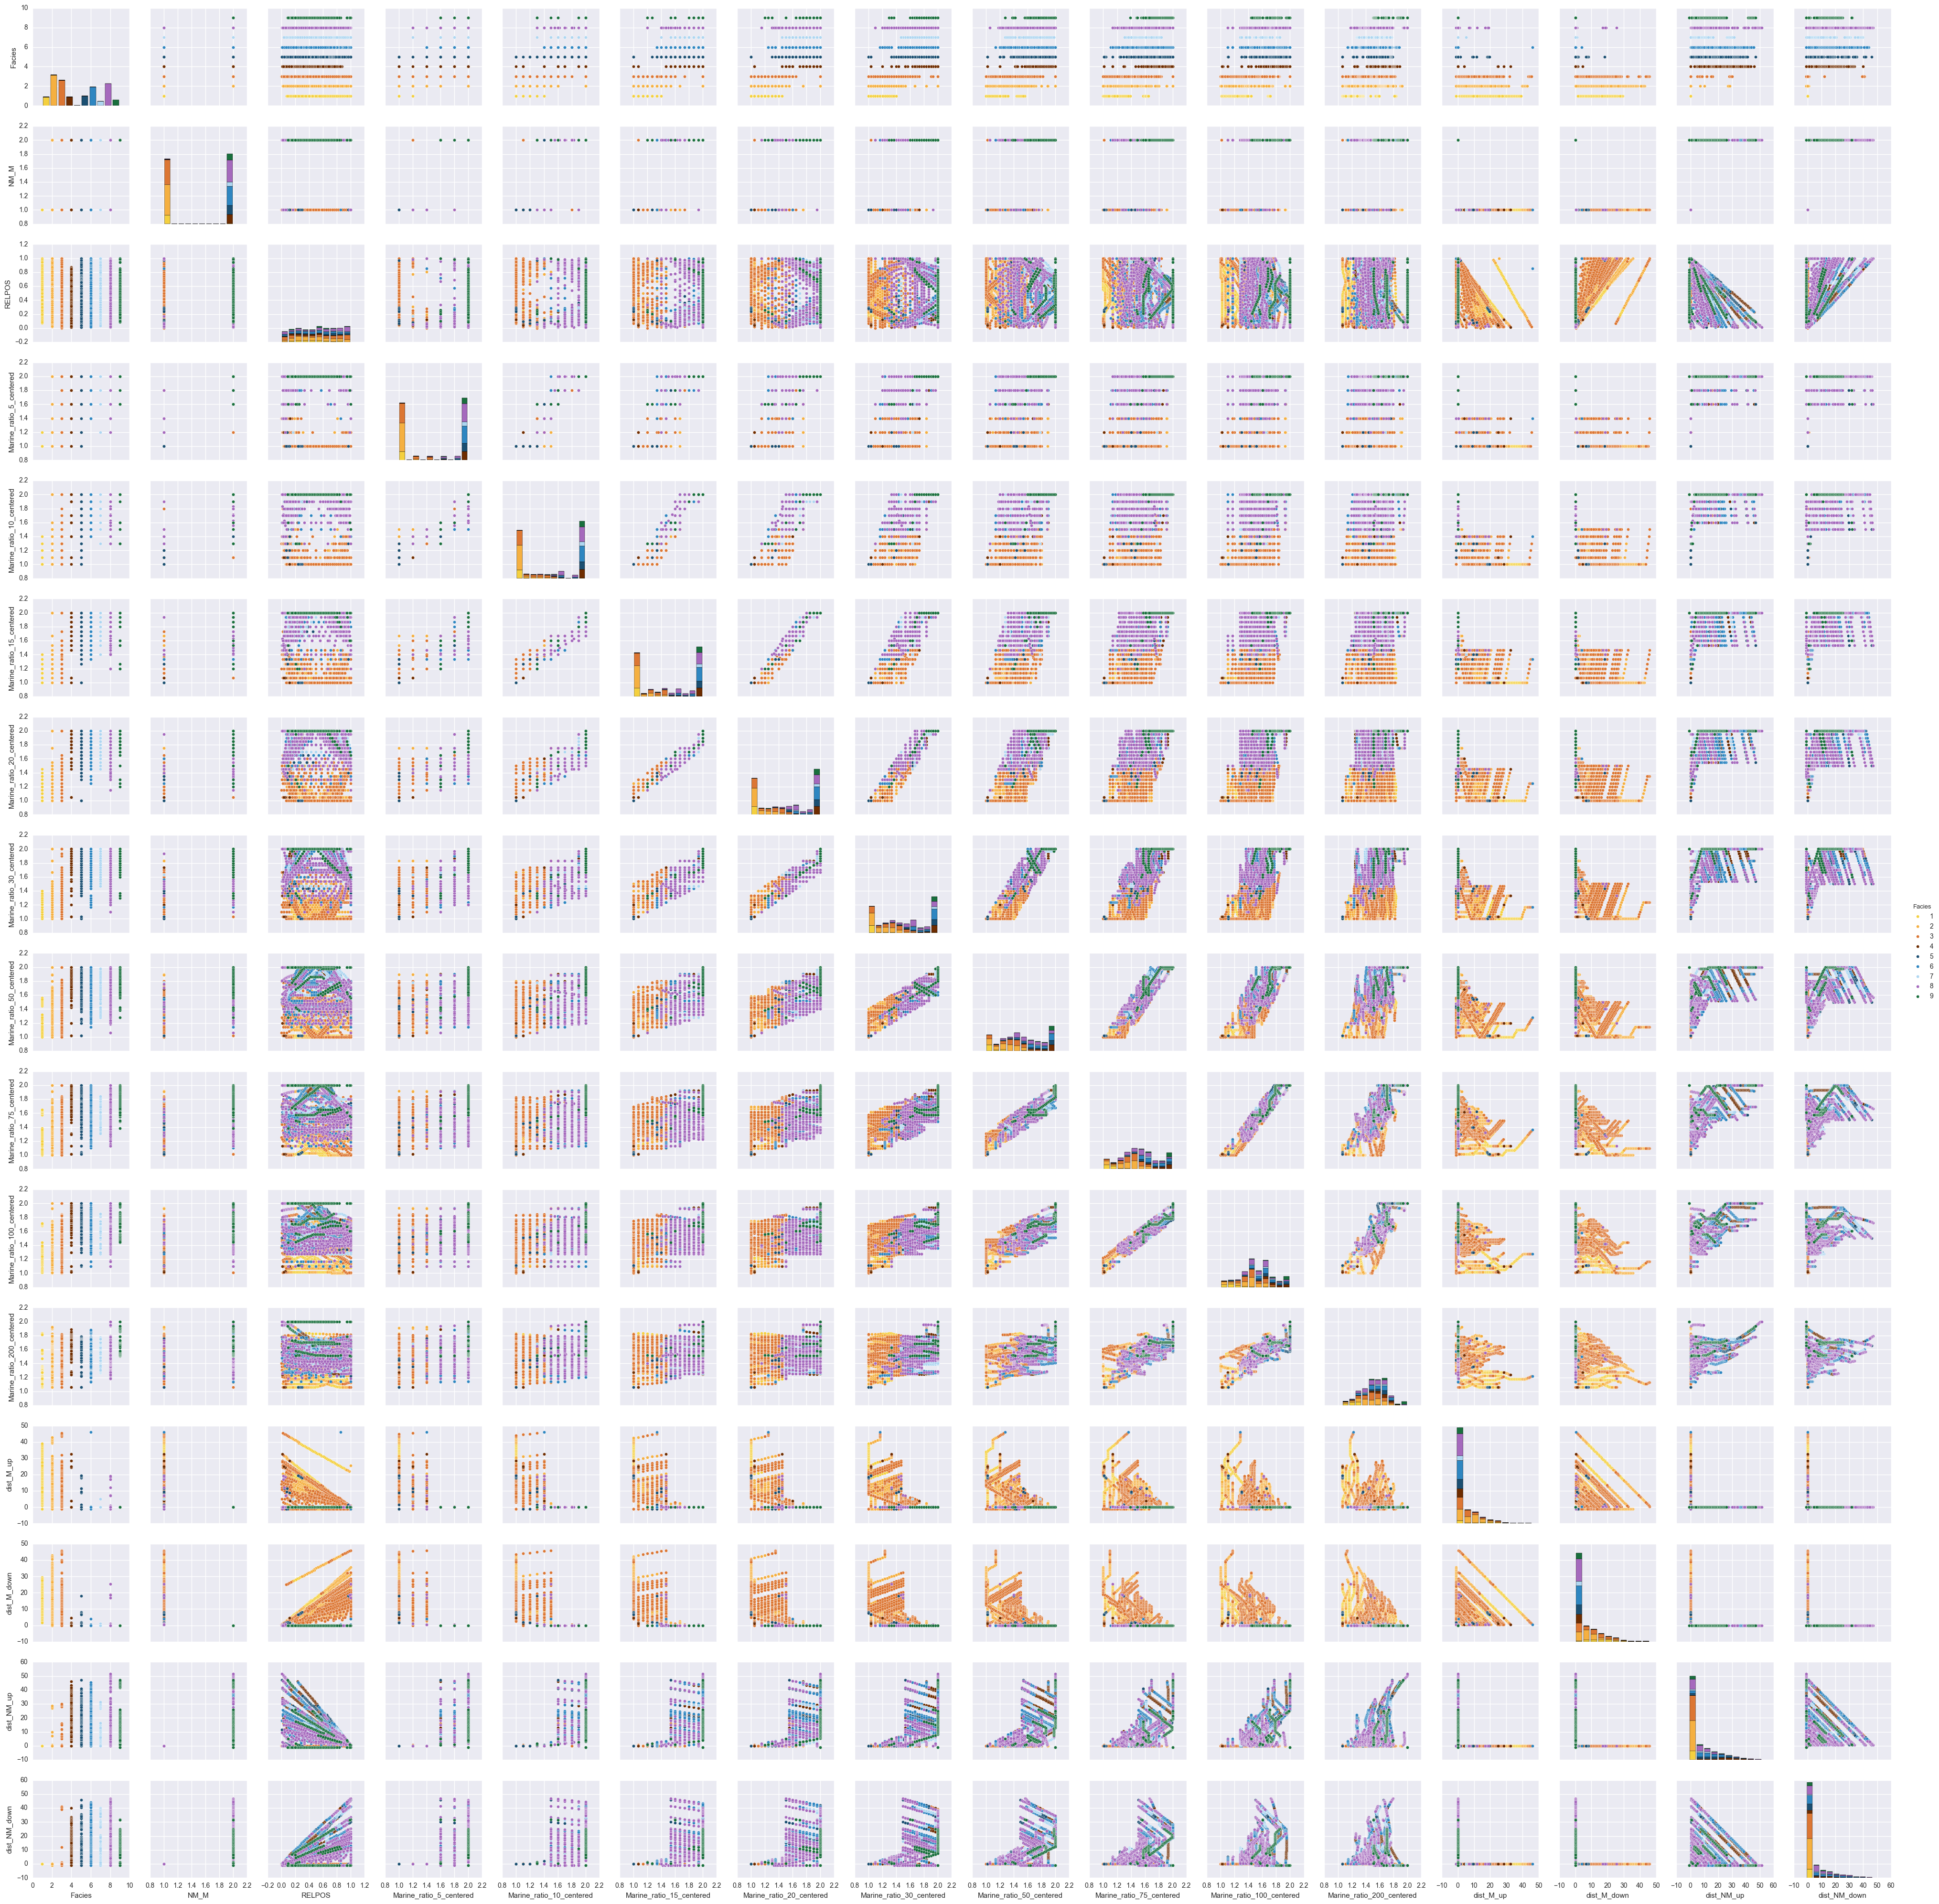

In [72]:
sns.set()
temp_df = combined_df
temp_df = temp_df.drop(['Formation', 'Well Name', 'Depth', 'GR', 'ILD_log10', 'DeltaPHI', 'PE', 'PHIND'], axis=1)
temp_df.dropna(inplace=True)
sns.pairplot(temp_df, hue='Facies', palette = flatui)

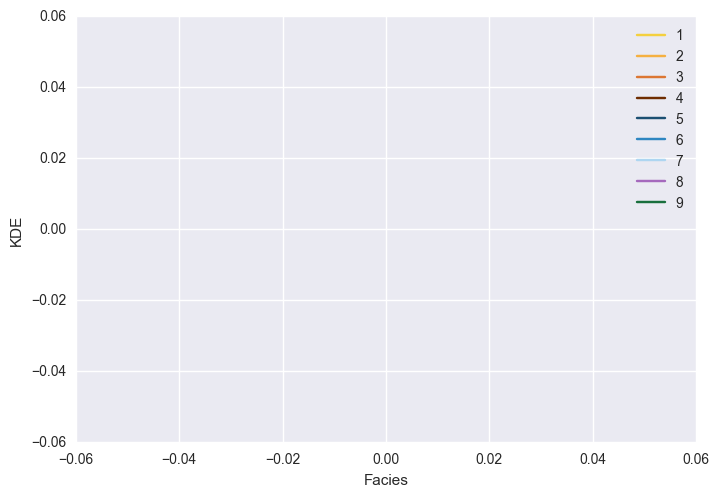

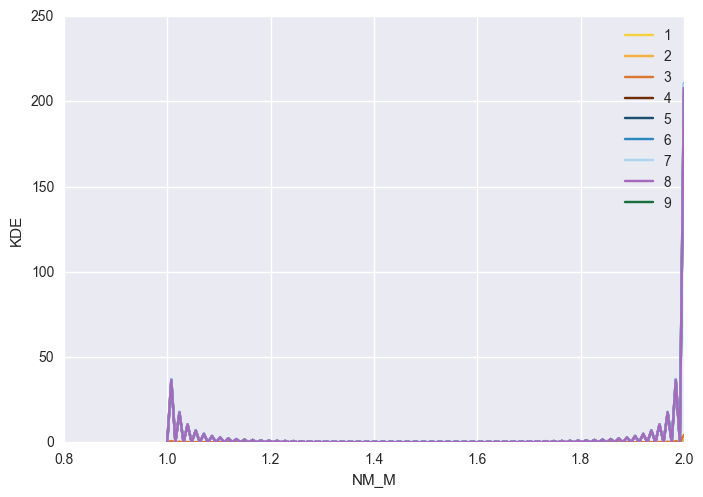

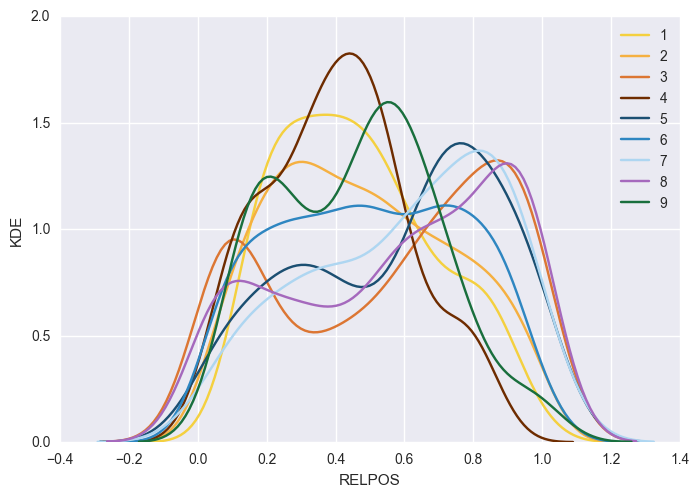

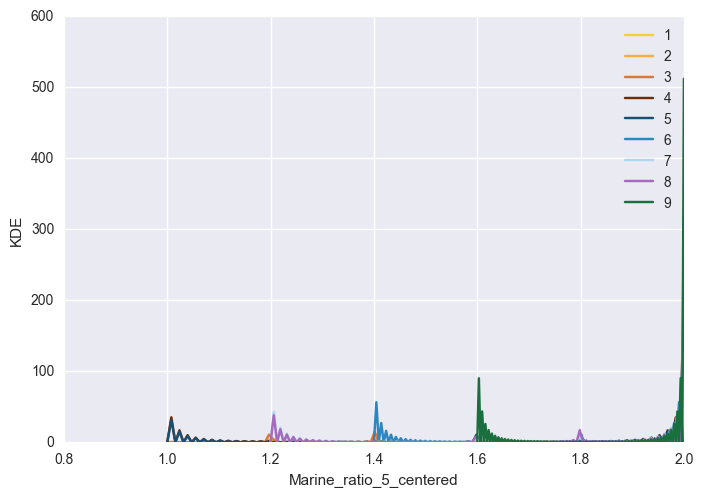

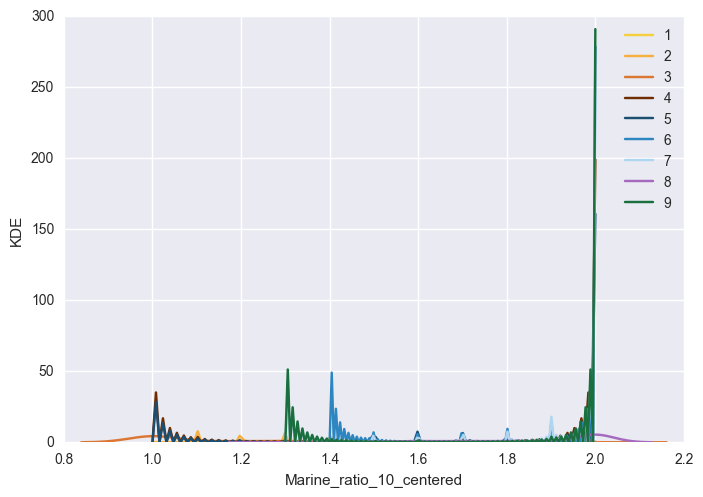

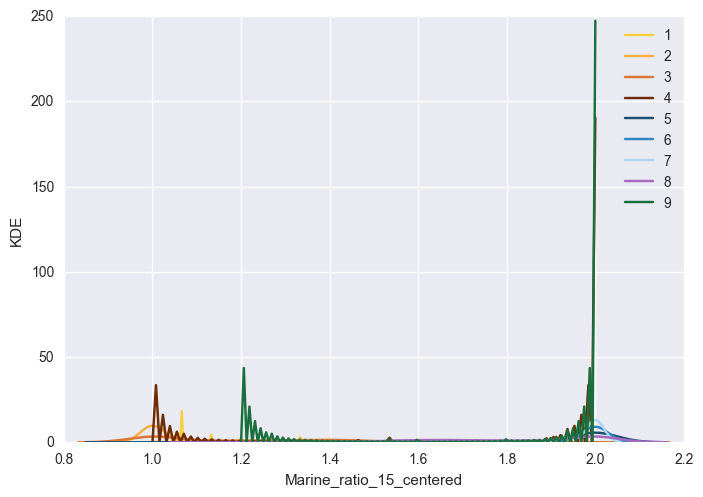

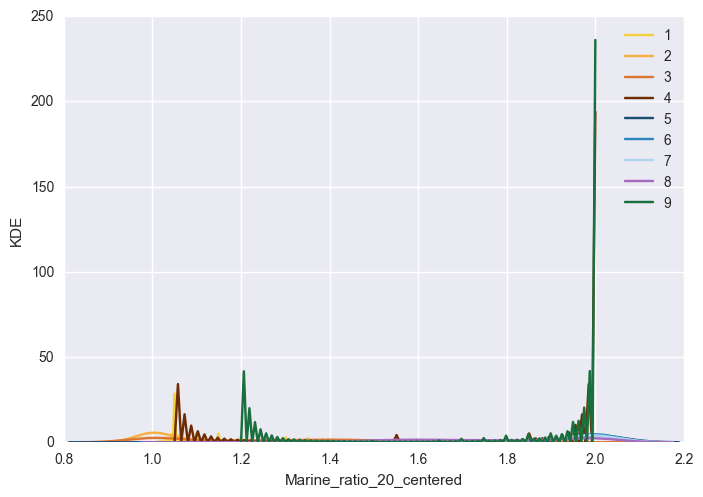

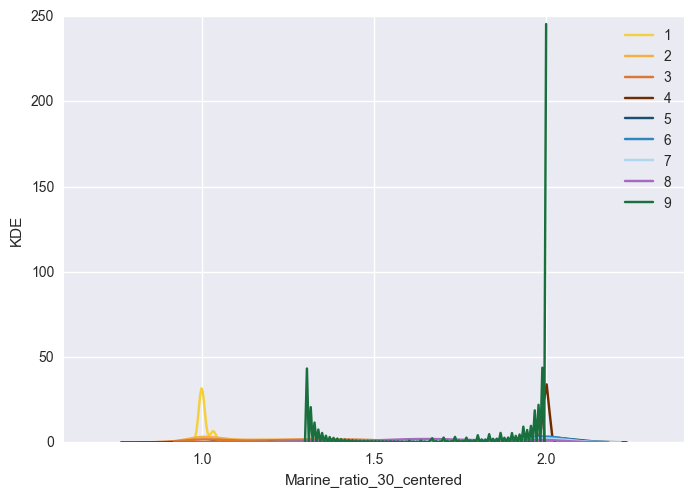

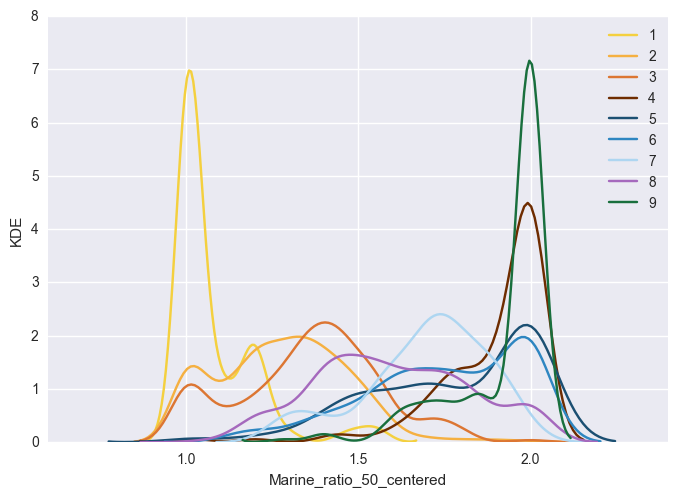

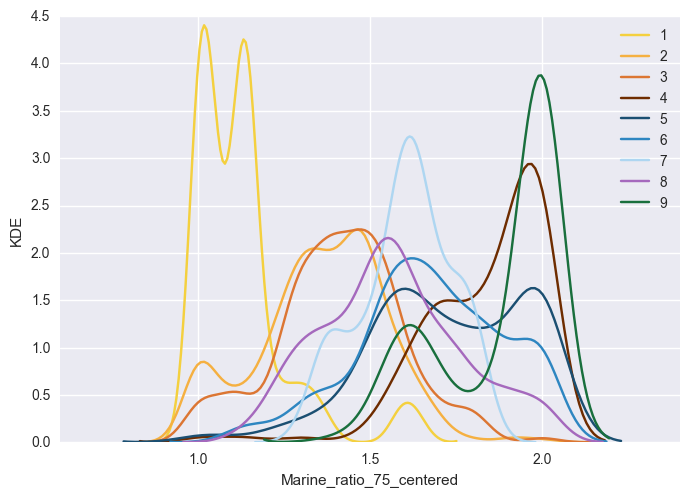

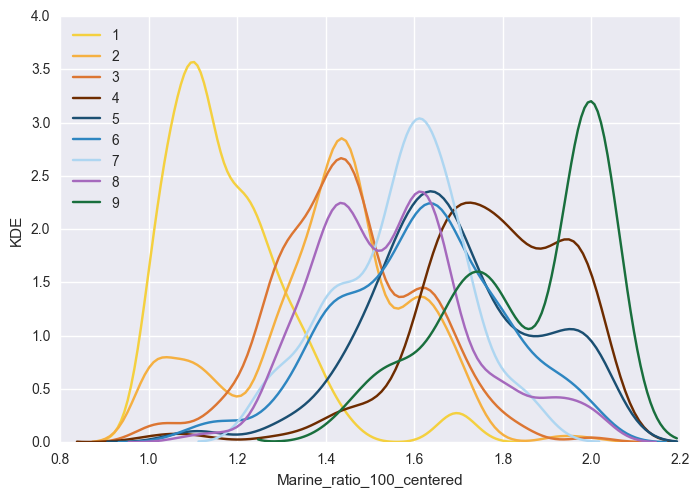

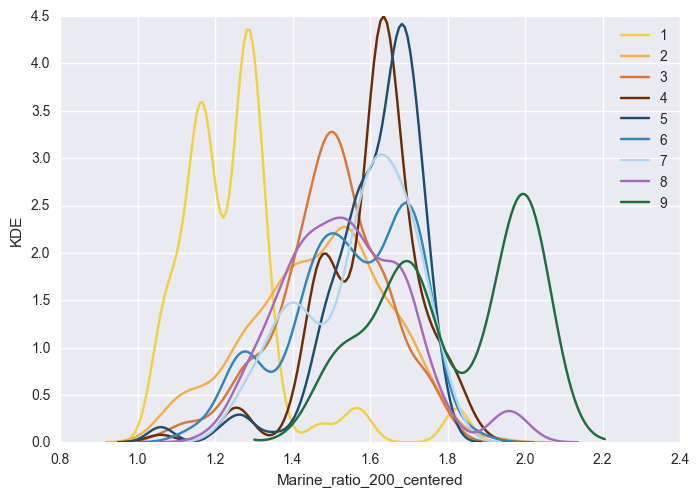

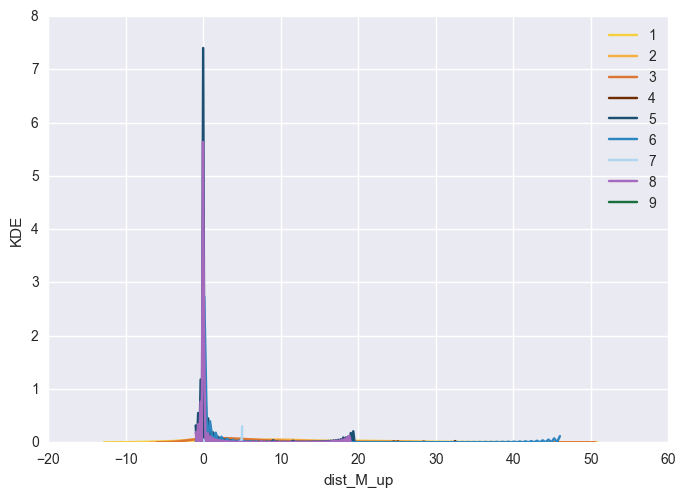

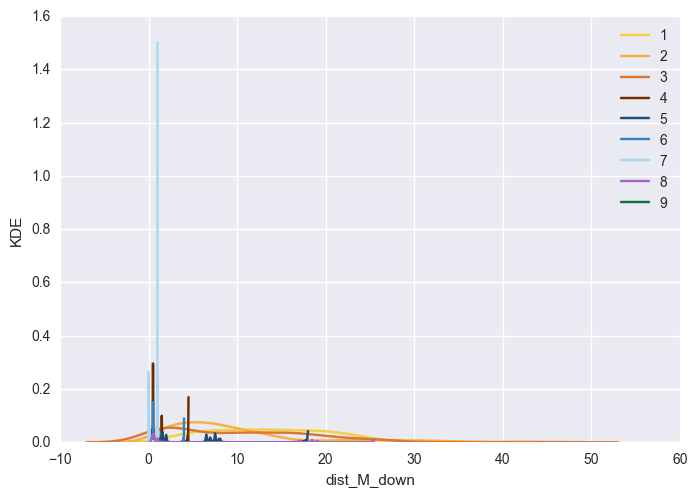

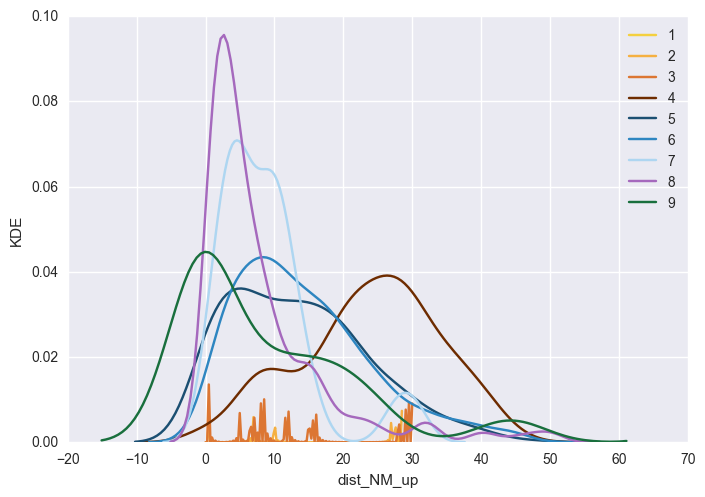

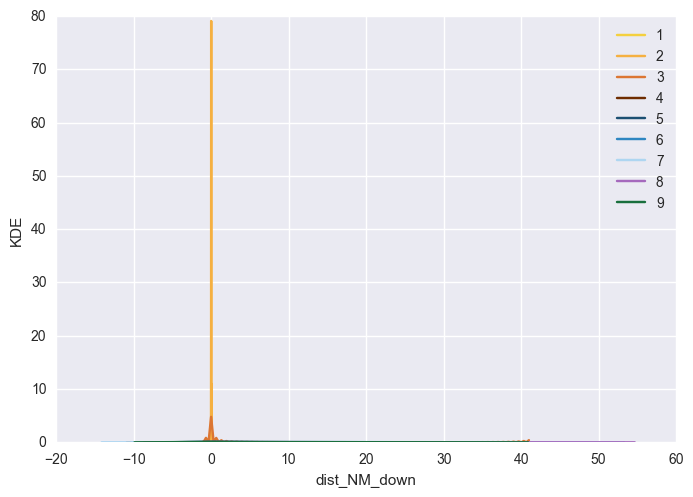

In [73]:
sns.set_palette(flatui)
list_variables = list(combined_df.columns.values)
list_variables_remove = ['Formation', 'Well Name', 'Depth', 'GR', 'ILD_log10', 'DeltaPHI', 'PE', 'PHIND']
for i in list_variables_remove:
    list_variables.remove(i)

#list_variables = ['GR_cD_step_level_1', 'GR_cA_step_level_1', 'GR_cD_step_level_2', 'GR_cA_step_level_2', 'GR_cD_step_level_3', 'GR_cA_step_level_3']
for a in list_variables:
    for i in np.arange(1, 10, 1):
        sns.kdeplot(combined_df[a][combined_df['Facies'] == i], label=i)
    plt.xlabel(a)
    plt.ylabel('KDE')
    plt.show()